In [26]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
from PIL import Image
from torchvision.datasets import ImageFolder

from torchvision import transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 128
num_epochs = 5
learning_rate = 0.01

In [3]:
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'archive'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Validation']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['Training', 'Validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation']}  

In [4]:
dataset_sizes

{'Training': 42669, 'Validation': 11649}

In [5]:
model = models.resnet18()
num_ftrs = model.fc.in_features
"""
for param in model.parameters():
    param.requires_grad = False
"""
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: male and female

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [6]:
"""
resnet = models.resnet50()
# Extract the convolutional layers
conv_layers = list(resnet.children())[:-2]
conv_model = nn.Sequential(*conv_layers)

# Freeze the convolutional layers
for param in conv_model.parameters():
    param.requires_grad = False

# Custom gender detection CNN
class GenderDetectionCNN(nn.Module):
    def __init__(self):
        super(GenderDetectionCNN, self).__init__()
        self.conv = conv_model
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(512, 256),  # Adjust input size to match the output of conv layers
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2)  # 2 classes: male and female
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Create an instance of the GenderDetectionCNN
model = GenderDetectionCNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
"""

'\nresnet = models.resnet50()\n# Extract the convolutional layers\nconv_layers = list(resnet.children())[:-2]\nconv_model = nn.Sequential(*conv_layers)\n\n# Freeze the convolutional layers\nfor param in conv_model.parameters():\n    param.requires_grad = False\n\n# Custom gender detection CNN\nclass GenderDetectionCNN(nn.Module):\n    def __init__(self):\n        super(GenderDetectionCNN, self).__init__()\n        self.conv = conv_model\n        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))\n        self.fc = nn.Sequential(\n            nn.Linear(512, 256),  # Adjust input size to match the output of conv layers\n            nn.ReLU(),\n            nn.Dropout(0.2),\n            nn.Linear(256, 2)  # 2 classes: male and female\n        )\n\n    def forward(self, x):\n        x = self.conv(x)\n        x = self.avgpool(x)\n        x = torch.flatten(x, 1)\n        x = self.fc(x)\n        return x\n\n# Create an instance of the GenderDetectionCNN\nmodel = GenderDetectionCNN()\ndevice = torch.d

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


In [7]:
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_batches = len(dataloaders[phase])

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                batch_loss = loss.item()
                print(f'Epoch [{epoch+1}/{num_epochs}], Phase: {phase}, Batch: [{batch_idx+1}/{total_batches}], Loss: {batch_loss:.4f}')
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        # Print loss for the epoch
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

    return model

In [8]:
model_trained = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch [1/5], Phase: Training, Batch: [1/334], Loss: 0.7139
Epoch [1/5], Phase: Training, Batch: [2/334], Loss: 0.6862
Epoch [1/5], Phase: Training, Batch: [3/334], Loss: 0.6912
Epoch [1/5], Phase: Training, Batch: [4/334], Loss: 0.6775
Epoch [1/5], Phase: Training, Batch: [5/334], Loss: 0.7757
Epoch [1/5], Phase: Training, Batch: [6/334], Loss: 0.7528
Epoch [1/5], Phase: Training, Batch: [7/334], Loss: 0.7261
Epoch [1/5], Phase: Training, Batch: [8/334], Loss: 0.7596
Epoch [1/5], Phase: Training, Batch: [9/334], Loss: 0.6374
Epoch [1/5], Phase: Training, Batch: [10/334], Loss: 0.6566
Epoch [1/5], Phase: Training, Batch: [11/334], Loss: 0.7220
Epoch [1/5], Phase: Training, Batch: [12/334], Loss: 0.6486
Epoch [1/5], Phase: Training, Batch: [13/334], Loss: 0.6387
Epoch [1/5], Phase: Training, Batch: [14/334], Loss: 0.7060
Epoch [1/5], Phase: Training, Batch: [15/334], Loss: 0.5957
Epoch [1/5], Phase: Training, Batch: [16/334], Loss: 0.5866
Epoch [1/5], Phase: Training, Batch: [17/334], Lo

Epoch [1/5], Phase: Training, Batch: [138/334], Loss: 0.2129
Epoch [1/5], Phase: Training, Batch: [139/334], Loss: 0.2222
Epoch [1/5], Phase: Training, Batch: [140/334], Loss: 0.2823
Epoch [1/5], Phase: Training, Batch: [141/334], Loss: 0.2170
Epoch [1/5], Phase: Training, Batch: [142/334], Loss: 0.1239
Epoch [1/5], Phase: Training, Batch: [143/334], Loss: 0.1436
Epoch [1/5], Phase: Training, Batch: [144/334], Loss: 0.2543
Epoch [1/5], Phase: Training, Batch: [145/334], Loss: 0.2044
Epoch [1/5], Phase: Training, Batch: [146/334], Loss: 0.1579
Epoch [1/5], Phase: Training, Batch: [147/334], Loss: 0.2707
Epoch [1/5], Phase: Training, Batch: [148/334], Loss: 0.1777
Epoch [1/5], Phase: Training, Batch: [149/334], Loss: 0.1605
Epoch [1/5], Phase: Training, Batch: [150/334], Loss: 0.3704
Epoch [1/5], Phase: Training, Batch: [151/334], Loss: 0.2287
Epoch [1/5], Phase: Training, Batch: [152/334], Loss: 0.2433
Epoch [1/5], Phase: Training, Batch: [153/334], Loss: 0.2198
Epoch [1/5], Phase: Trai

Epoch [1/5], Phase: Training, Batch: [273/334], Loss: 0.1207
Epoch [1/5], Phase: Training, Batch: [274/334], Loss: 0.0976
Epoch [1/5], Phase: Training, Batch: [275/334], Loss: 0.1924
Epoch [1/5], Phase: Training, Batch: [276/334], Loss: 0.0858
Epoch [1/5], Phase: Training, Batch: [277/334], Loss: 0.2328
Epoch [1/5], Phase: Training, Batch: [278/334], Loss: 0.1157
Epoch [1/5], Phase: Training, Batch: [279/334], Loss: 0.1915
Epoch [1/5], Phase: Training, Batch: [280/334], Loss: 0.2983
Epoch [1/5], Phase: Training, Batch: [281/334], Loss: 0.0608
Epoch [1/5], Phase: Training, Batch: [282/334], Loss: 0.1842
Epoch [1/5], Phase: Training, Batch: [283/334], Loss: 0.1161
Epoch [1/5], Phase: Training, Batch: [284/334], Loss: 0.1171
Epoch [1/5], Phase: Training, Batch: [285/334], Loss: 0.1795
Epoch [1/5], Phase: Training, Batch: [286/334], Loss: 0.1292
Epoch [1/5], Phase: Training, Batch: [287/334], Loss: 0.2221
Epoch [1/5], Phase: Training, Batch: [288/334], Loss: 0.0703
Epoch [1/5], Phase: Trai

Epoch [1/5], Phase: Validation, Batch: [73/92], Loss: 0.3179
Epoch [1/5], Phase: Validation, Batch: [74/92], Loss: 0.3661
Epoch [1/5], Phase: Validation, Batch: [75/92], Loss: 0.3523
Epoch [1/5], Phase: Validation, Batch: [76/92], Loss: 0.3862
Epoch [1/5], Phase: Validation, Batch: [77/92], Loss: 0.3189
Epoch [1/5], Phase: Validation, Batch: [78/92], Loss: 0.3995
Epoch [1/5], Phase: Validation, Batch: [79/92], Loss: 0.3963
Epoch [1/5], Phase: Validation, Batch: [80/92], Loss: 0.2455
Epoch [1/5], Phase: Validation, Batch: [81/92], Loss: 0.4292
Epoch [1/5], Phase: Validation, Batch: [82/92], Loss: 0.3305
Epoch [1/5], Phase: Validation, Batch: [83/92], Loss: 0.3587
Epoch [1/5], Phase: Validation, Batch: [84/92], Loss: 0.2816
Epoch [1/5], Phase: Validation, Batch: [85/92], Loss: 0.2321
Epoch [1/5], Phase: Validation, Batch: [86/92], Loss: 0.2780
Epoch [1/5], Phase: Validation, Batch: [87/92], Loss: 0.2911
Epoch [1/5], Phase: Validation, Batch: [88/92], Loss: 0.4947
Epoch [1/5], Phase: Vali

Epoch [2/5], Phase: Training, Batch: [117/334], Loss: 0.1098
Epoch [2/5], Phase: Training, Batch: [118/334], Loss: 0.1115
Epoch [2/5], Phase: Training, Batch: [119/334], Loss: 0.1051
Epoch [2/5], Phase: Training, Batch: [120/334], Loss: 0.1709
Epoch [2/5], Phase: Training, Batch: [121/334], Loss: 0.0856
Epoch [2/5], Phase: Training, Batch: [122/334], Loss: 0.0955
Epoch [2/5], Phase: Training, Batch: [123/334], Loss: 0.1565
Epoch [2/5], Phase: Training, Batch: [124/334], Loss: 0.0729
Epoch [2/5], Phase: Training, Batch: [125/334], Loss: 0.0564
Epoch [2/5], Phase: Training, Batch: [126/334], Loss: 0.1496
Epoch [2/5], Phase: Training, Batch: [127/334], Loss: 0.2157
Epoch [2/5], Phase: Training, Batch: [128/334], Loss: 0.1393
Epoch [2/5], Phase: Training, Batch: [129/334], Loss: 0.1444
Epoch [2/5], Phase: Training, Batch: [130/334], Loss: 0.1099
Epoch [2/5], Phase: Training, Batch: [131/334], Loss: 0.1453
Epoch [2/5], Phase: Training, Batch: [132/334], Loss: 0.0732
Epoch [2/5], Phase: Trai

Epoch [2/5], Phase: Training, Batch: [252/334], Loss: 0.1108
Epoch [2/5], Phase: Training, Batch: [253/334], Loss: 0.2211
Epoch [2/5], Phase: Training, Batch: [254/334], Loss: 0.1259
Epoch [2/5], Phase: Training, Batch: [255/334], Loss: 0.0956
Epoch [2/5], Phase: Training, Batch: [256/334], Loss: 0.0376
Epoch [2/5], Phase: Training, Batch: [257/334], Loss: 0.2896
Epoch [2/5], Phase: Training, Batch: [258/334], Loss: 0.1272
Epoch [2/5], Phase: Training, Batch: [259/334], Loss: 0.1642
Epoch [2/5], Phase: Training, Batch: [260/334], Loss: 0.1471
Epoch [2/5], Phase: Training, Batch: [261/334], Loss: 0.1058
Epoch [2/5], Phase: Training, Batch: [262/334], Loss: 0.0970
Epoch [2/5], Phase: Training, Batch: [263/334], Loss: 0.0862
Epoch [2/5], Phase: Training, Batch: [264/334], Loss: 0.0970
Epoch [2/5], Phase: Training, Batch: [265/334], Loss: 0.1185
Epoch [2/5], Phase: Training, Batch: [266/334], Loss: 0.1757
Epoch [2/5], Phase: Training, Batch: [267/334], Loss: 0.1426
Epoch [2/5], Phase: Trai

Epoch [2/5], Phase: Validation, Batch: [52/92], Loss: 0.1932
Epoch [2/5], Phase: Validation, Batch: [53/92], Loss: 0.1655
Epoch [2/5], Phase: Validation, Batch: [54/92], Loss: 0.1000
Epoch [2/5], Phase: Validation, Batch: [55/92], Loss: 0.1584
Epoch [2/5], Phase: Validation, Batch: [56/92], Loss: 0.1432
Epoch [2/5], Phase: Validation, Batch: [57/92], Loss: 0.1344
Epoch [2/5], Phase: Validation, Batch: [58/92], Loss: 0.0831
Epoch [2/5], Phase: Validation, Batch: [59/92], Loss: 0.1292
Epoch [2/5], Phase: Validation, Batch: [60/92], Loss: 0.1608
Epoch [2/5], Phase: Validation, Batch: [61/92], Loss: 0.1113
Epoch [2/5], Phase: Validation, Batch: [62/92], Loss: 0.1405
Epoch [2/5], Phase: Validation, Batch: [63/92], Loss: 0.1417
Epoch [2/5], Phase: Validation, Batch: [64/92], Loss: 0.1689
Epoch [2/5], Phase: Validation, Batch: [65/92], Loss: 0.1767
Epoch [2/5], Phase: Validation, Batch: [66/92], Loss: 0.1253
Epoch [2/5], Phase: Validation, Batch: [67/92], Loss: 0.1699
Epoch [2/5], Phase: Vali

Epoch [3/5], Phase: Training, Batch: [95/334], Loss: 0.0712
Epoch [3/5], Phase: Training, Batch: [96/334], Loss: 0.1517
Epoch [3/5], Phase: Training, Batch: [97/334], Loss: 0.1128
Epoch [3/5], Phase: Training, Batch: [98/334], Loss: 0.1545
Epoch [3/5], Phase: Training, Batch: [99/334], Loss: 0.0656
Epoch [3/5], Phase: Training, Batch: [100/334], Loss: 0.0452
Epoch [3/5], Phase: Training, Batch: [101/334], Loss: 0.0587
Epoch [3/5], Phase: Training, Batch: [102/334], Loss: 0.0683
Epoch [3/5], Phase: Training, Batch: [103/334], Loss: 0.0649
Epoch [3/5], Phase: Training, Batch: [104/334], Loss: 0.1011
Epoch [3/5], Phase: Training, Batch: [105/334], Loss: 0.0714
Epoch [3/5], Phase: Training, Batch: [106/334], Loss: 0.0926
Epoch [3/5], Phase: Training, Batch: [107/334], Loss: 0.0668
Epoch [3/5], Phase: Training, Batch: [108/334], Loss: 0.0195
Epoch [3/5], Phase: Training, Batch: [109/334], Loss: 0.0768
Epoch [3/5], Phase: Training, Batch: [110/334], Loss: 0.0433
Epoch [3/5], Phase: Training,

Epoch [3/5], Phase: Training, Batch: [230/334], Loss: 0.0670
Epoch [3/5], Phase: Training, Batch: [231/334], Loss: 0.1289
Epoch [3/5], Phase: Training, Batch: [232/334], Loss: 0.2241
Epoch [3/5], Phase: Training, Batch: [233/334], Loss: 0.1151
Epoch [3/5], Phase: Training, Batch: [234/334], Loss: 0.0556
Epoch [3/5], Phase: Training, Batch: [235/334], Loss: 0.1263
Epoch [3/5], Phase: Training, Batch: [236/334], Loss: 0.0675
Epoch [3/5], Phase: Training, Batch: [237/334], Loss: 0.1025
Epoch [3/5], Phase: Training, Batch: [238/334], Loss: 0.0798
Epoch [3/5], Phase: Training, Batch: [239/334], Loss: 0.0338
Epoch [3/5], Phase: Training, Batch: [240/334], Loss: 0.1985
Epoch [3/5], Phase: Training, Batch: [241/334], Loss: 0.0968
Epoch [3/5], Phase: Training, Batch: [242/334], Loss: 0.0818
Epoch [3/5], Phase: Training, Batch: [243/334], Loss: 0.1047
Epoch [3/5], Phase: Training, Batch: [244/334], Loss: 0.0582
Epoch [3/5], Phase: Training, Batch: [245/334], Loss: 0.1810
Epoch [3/5], Phase: Trai

Epoch [3/5], Phase: Validation, Batch: [30/92], Loss: 0.0947
Epoch [3/5], Phase: Validation, Batch: [31/92], Loss: 0.0486
Epoch [3/5], Phase: Validation, Batch: [32/92], Loss: 0.1185
Epoch [3/5], Phase: Validation, Batch: [33/92], Loss: 0.1416
Epoch [3/5], Phase: Validation, Batch: [34/92], Loss: 0.1380
Epoch [3/5], Phase: Validation, Batch: [35/92], Loss: 0.1477
Epoch [3/5], Phase: Validation, Batch: [36/92], Loss: 0.0836
Epoch [3/5], Phase: Validation, Batch: [37/92], Loss: 0.1176
Epoch [3/5], Phase: Validation, Batch: [38/92], Loss: 0.1708
Epoch [3/5], Phase: Validation, Batch: [39/92], Loss: 0.1164
Epoch [3/5], Phase: Validation, Batch: [40/92], Loss: 0.1714
Epoch [3/5], Phase: Validation, Batch: [41/92], Loss: 0.0576
Epoch [3/5], Phase: Validation, Batch: [42/92], Loss: 0.0952
Epoch [3/5], Phase: Validation, Batch: [43/92], Loss: 0.1886
Epoch [3/5], Phase: Validation, Batch: [44/92], Loss: 0.0855
Epoch [3/5], Phase: Validation, Batch: [45/92], Loss: 0.0870
Epoch [3/5], Phase: Vali

Epoch [4/5], Phase: Training, Batch: [73/334], Loss: 0.0393
Epoch [4/5], Phase: Training, Batch: [74/334], Loss: 0.0664
Epoch [4/5], Phase: Training, Batch: [75/334], Loss: 0.0358
Epoch [4/5], Phase: Training, Batch: [76/334], Loss: 0.0440
Epoch [4/5], Phase: Training, Batch: [77/334], Loss: 0.0554
Epoch [4/5], Phase: Training, Batch: [78/334], Loss: 0.0778
Epoch [4/5], Phase: Training, Batch: [79/334], Loss: 0.0729
Epoch [4/5], Phase: Training, Batch: [80/334], Loss: 0.0554
Epoch [4/5], Phase: Training, Batch: [81/334], Loss: 0.0769
Epoch [4/5], Phase: Training, Batch: [82/334], Loss: 0.0845
Epoch [4/5], Phase: Training, Batch: [83/334], Loss: 0.0683
Epoch [4/5], Phase: Training, Batch: [84/334], Loss: 0.0688
Epoch [4/5], Phase: Training, Batch: [85/334], Loss: 0.0794
Epoch [4/5], Phase: Training, Batch: [86/334], Loss: 0.0602
Epoch [4/5], Phase: Training, Batch: [87/334], Loss: 0.0449
Epoch [4/5], Phase: Training, Batch: [88/334], Loss: 0.0505
Epoch [4/5], Phase: Training, Batch: [89

Epoch [4/5], Phase: Training, Batch: [208/334], Loss: 0.0982
Epoch [4/5], Phase: Training, Batch: [209/334], Loss: 0.1004
Epoch [4/5], Phase: Training, Batch: [210/334], Loss: 0.1244
Epoch [4/5], Phase: Training, Batch: [211/334], Loss: 0.1451
Epoch [4/5], Phase: Training, Batch: [212/334], Loss: 0.1371
Epoch [4/5], Phase: Training, Batch: [213/334], Loss: 0.1248
Epoch [4/5], Phase: Training, Batch: [214/334], Loss: 0.0626
Epoch [4/5], Phase: Training, Batch: [215/334], Loss: 0.0782
Epoch [4/5], Phase: Training, Batch: [216/334], Loss: 0.0100
Epoch [4/5], Phase: Training, Batch: [217/334], Loss: 0.0296
Epoch [4/5], Phase: Training, Batch: [218/334], Loss: 0.1201
Epoch [4/5], Phase: Training, Batch: [219/334], Loss: 0.0299
Epoch [4/5], Phase: Training, Batch: [220/334], Loss: 0.0720
Epoch [4/5], Phase: Training, Batch: [221/334], Loss: 0.1238
Epoch [4/5], Phase: Training, Batch: [222/334], Loss: 0.0438
Epoch [4/5], Phase: Training, Batch: [223/334], Loss: 0.0409
Epoch [4/5], Phase: Trai

Epoch [4/5], Phase: Validation, Batch: [8/92], Loss: 0.1216
Epoch [4/5], Phase: Validation, Batch: [9/92], Loss: 0.1307
Epoch [4/5], Phase: Validation, Batch: [10/92], Loss: 0.0588
Epoch [4/5], Phase: Validation, Batch: [11/92], Loss: 0.1604
Epoch [4/5], Phase: Validation, Batch: [12/92], Loss: 0.2048
Epoch [4/5], Phase: Validation, Batch: [13/92], Loss: 0.0591
Epoch [4/5], Phase: Validation, Batch: [14/92], Loss: 0.1256
Epoch [4/5], Phase: Validation, Batch: [15/92], Loss: 0.1575
Epoch [4/5], Phase: Validation, Batch: [16/92], Loss: 0.0928
Epoch [4/5], Phase: Validation, Batch: [17/92], Loss: 0.1134
Epoch [4/5], Phase: Validation, Batch: [18/92], Loss: 0.1345
Epoch [4/5], Phase: Validation, Batch: [19/92], Loss: 0.1307
Epoch [4/5], Phase: Validation, Batch: [20/92], Loss: 0.1275
Epoch [4/5], Phase: Validation, Batch: [21/92], Loss: 0.0894
Epoch [4/5], Phase: Validation, Batch: [22/92], Loss: 0.0746
Epoch [4/5], Phase: Validation, Batch: [23/92], Loss: 0.1871
Epoch [4/5], Phase: Valida

Epoch [5/5], Phase: Training, Batch: [51/334], Loss: 0.0382
Epoch [5/5], Phase: Training, Batch: [52/334], Loss: 0.0740
Epoch [5/5], Phase: Training, Batch: [53/334], Loss: 0.0487
Epoch [5/5], Phase: Training, Batch: [54/334], Loss: 0.0564
Epoch [5/5], Phase: Training, Batch: [55/334], Loss: 0.0277
Epoch [5/5], Phase: Training, Batch: [56/334], Loss: 0.1179
Epoch [5/5], Phase: Training, Batch: [57/334], Loss: 0.0442
Epoch [5/5], Phase: Training, Batch: [58/334], Loss: 0.0384
Epoch [5/5], Phase: Training, Batch: [59/334], Loss: 0.0283
Epoch [5/5], Phase: Training, Batch: [60/334], Loss: 0.0736
Epoch [5/5], Phase: Training, Batch: [61/334], Loss: 0.0174
Epoch [5/5], Phase: Training, Batch: [62/334], Loss: 0.0508
Epoch [5/5], Phase: Training, Batch: [63/334], Loss: 0.0979
Epoch [5/5], Phase: Training, Batch: [64/334], Loss: 0.0489
Epoch [5/5], Phase: Training, Batch: [65/334], Loss: 0.0301
Epoch [5/5], Phase: Training, Batch: [66/334], Loss: 0.0227
Epoch [5/5], Phase: Training, Batch: [67

Epoch [5/5], Phase: Training, Batch: [187/334], Loss: 0.1286
Epoch [5/5], Phase: Training, Batch: [188/334], Loss: 0.0583
Epoch [5/5], Phase: Training, Batch: [189/334], Loss: 0.0323
Epoch [5/5], Phase: Training, Batch: [190/334], Loss: 0.0513
Epoch [5/5], Phase: Training, Batch: [191/334], Loss: 0.0251
Epoch [5/5], Phase: Training, Batch: [192/334], Loss: 0.1103
Epoch [5/5], Phase: Training, Batch: [193/334], Loss: 0.0346
Epoch [5/5], Phase: Training, Batch: [194/334], Loss: 0.0338
Epoch [5/5], Phase: Training, Batch: [195/334], Loss: 0.0784
Epoch [5/5], Phase: Training, Batch: [196/334], Loss: 0.0590
Epoch [5/5], Phase: Training, Batch: [197/334], Loss: 0.0652
Epoch [5/5], Phase: Training, Batch: [198/334], Loss: 0.0838
Epoch [5/5], Phase: Training, Batch: [199/334], Loss: 0.0388
Epoch [5/5], Phase: Training, Batch: [200/334], Loss: 0.0310
Epoch [5/5], Phase: Training, Batch: [201/334], Loss: 0.0714
Epoch [5/5], Phase: Training, Batch: [202/334], Loss: 0.1282
Epoch [5/5], Phase: Trai

Epoch [5/5], Phase: Training, Batch: [322/334], Loss: 0.0687
Epoch [5/5], Phase: Training, Batch: [323/334], Loss: 0.0441
Epoch [5/5], Phase: Training, Batch: [324/334], Loss: 0.0712
Epoch [5/5], Phase: Training, Batch: [325/334], Loss: 0.0874
Epoch [5/5], Phase: Training, Batch: [326/334], Loss: 0.0510
Epoch [5/5], Phase: Training, Batch: [327/334], Loss: 0.0298
Epoch [5/5], Phase: Training, Batch: [328/334], Loss: 0.0446
Epoch [5/5], Phase: Training, Batch: [329/334], Loss: 0.0385
Epoch [5/5], Phase: Training, Batch: [330/334], Loss: 0.0448
Epoch [5/5], Phase: Training, Batch: [331/334], Loss: 0.0174
Epoch [5/5], Phase: Training, Batch: [332/334], Loss: 0.0512
Epoch [5/5], Phase: Training, Batch: [333/334], Loss: 0.0971
Epoch [5/5], Phase: Training, Batch: [334/334], Loss: 0.0155
Training Loss: 0.0473 Acc: 0.9831
Epoch [5/5], Phase: Validation, Batch: [1/92], Loss: 0.0737
Epoch [5/5], Phase: Validation, Batch: [2/92], Loss: 0.1150
Epoch [5/5], Phase: Validation, Batch: [3/92], Loss: 

In [9]:
torch.save(model.state_dict(), 'resnet_model_2.pth')

In [10]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Load the trained model  
model.eval()  # Set model to evaluation mode
 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:

# Define class labels
class_labels = ['Male', 'Female']
# Define directories
male_dir = 'TEST/male'
female_dir = 'TEST/female'

# Perform inference on images in male directory
print("Predictions for male images:")
for filename in os.listdir(male_dir):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        image_path = os.path.join(male_dir, filename)
        input_image = preprocess_image(image_path).to(device)

        with torch.no_grad():
            output = model(input_image)
            probabilities = torch.softmax(output, dim=1)
            predicted_class_index = torch.argmax(probabilities, dim=1).item()
            predicted_class = class_labels[1-predicted_class_index]
            confidence_score = probabilities[0][predicted_class_index].item()

        print(f"Image: {filename}, Predicted Gender: {predicted_class}, Confidence: {confidence_score:.2f}")


Predictions for male images:
Image: 090544.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 090652.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 090700.jpg.jpg, Predicted Gender: Male, Confidence: 0.92
Image: 090781.jpg.jpg, Predicted Gender: Male, Confidence: 0.96
Image: 090818.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 090888.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 090990.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 091025.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 091228.jpg.jpg, Predicted Gender: Male, Confidence: 0.80
Image: 091270.jpg.jpg, Predicted Gender: Male, Confidence: 0.97
Image: 091326.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 091386.jpg.jpg, Predicted Gender: Female, Confidence: 0.83
Image: 091397.jpg.jpg, Predicted Gender: Male, Confidence: 0.88
Image: 091435.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 091448.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 09

Image: 098857.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 098889.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 098922.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 098930.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 098963.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 099026.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 099029.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 099044.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 099054.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 099144.jpg.jpg, Predicted Gender: Male, Confidence: 0.98
Image: 099200.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 099240.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 099300.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 099312.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 099357.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 099428.jpg.jpg, Predicted Gender:

Image: 107058.jpg.jpg, Predicted Gender: Male, Confidence: 0.98
Image: 107069.jpg.jpg, Predicted Gender: Male, Confidence: 0.98
Image: 107099.jpg.jpg, Predicted Gender: Male, Confidence: 0.60
Image: 107105.jpg.jpg, Predicted Gender: Male, Confidence: 0.95
Image: 107311.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 107399.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 107430.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 107474.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 107491.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 107561.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 107584.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 107620.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 107821.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 107865.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 108020.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 108086.jpg.jpg, Predicted Gender:

Image: 114266.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 114373.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 114536.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 114692.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 114695.jpg.jpg, Predicted Gender: Female, Confidence: 0.57
Image: 114756.jpg.jpg, Predicted Gender: Male, Confidence: 0.95
Image: 114831.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 114832.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 114882.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 114897.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 114949.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 115023.jpg.jpg, Predicted Gender: Male, Confidence: 0.59
Image: 115041.jpg.jpg, Predicted Gender: Female, Confidence: 0.98
Image: 115118.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 115145.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 115187.jpg.jpg, Predicted Gen

Image: 123278.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123287.jpg.jpg, Predicted Gender: Female, Confidence: 0.76
Image: 123416.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123456.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123514.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123517.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123553.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123571.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123641.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123647.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123658.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123735.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123805.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123844.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123916.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 123972.jpg.jpg, Predicted Gende

Image: 132510.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 132532.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 132680.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 132691.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 132854.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 132895.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 132947.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 133029.jpg.jpg, Predicted Gender: Female, Confidence: 0.75
Image: 133042.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 133156.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 133198.jpg.jpg, Predicted Gender: Female, Confidence: 0.65
Image: 133204.jpg.jpg, Predicted Gender: Male, Confidence: 0.60
Image: 133255.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 133360.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 133378.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 133413.jpg.jpg, Predicted Gen

Image: 141468.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 141579.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 141604.jpg.jpg, Predicted Gender: Male, Confidence: 0.98
Image: 141643.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 141663.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 141694.jpg.jpg, Predicted Gender: Male, Confidence: 0.85
Image: 141701.jpg.jpg, Predicted Gender: Male, Confidence: 0.88
Image: 141778.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 141841.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 141843.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 141896.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 141903.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 141933.jpg.jpg, Predicted Gender: Male, Confidence: 0.92
Image: 142008.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 142022.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 142088.jpg.jpg, Predicted Gender:

Image: 150595.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 150598.jpg.jpg, Predicted Gender: Female, Confidence: 0.76
Image: 150611.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 150654.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 150730.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 150813.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 150858.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 150947.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 150972.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 151012.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 151082.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 151092.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 151111.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 151123.jpg.jpg, Predicted Gender: Male, Confidence: 0.86
Image: 151168.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 151251.jpg.jpg, Predicted Gende

Image: 158753.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 158790.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 158824.jpg.jpg, Predicted Gender: Male, Confidence: 0.98
Image: 158927.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 158948.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 159112.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 159180.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 159282.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 159299.jpg.jpg, Predicted Gender: Male, Confidence: 0.97
Image: 159304.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 159341.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 159370.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 159376.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 159465.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 159493.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 159600.jpg.jpg, Predicted Gender:

Image: 166310.jpg.jpg, Predicted Gender: Male, Confidence: 0.95
Image: 166340.jpg.jpg, Predicted Gender: Male, Confidence: 0.92
Image: 166573.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 166646.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 166741.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 166790.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 166813.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 166823.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 166901.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 167011.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 167023.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 167118.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 167208.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 167300.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 167325.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 167330.jpg.jpg, Predicted Gender:

Image: 174103.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 174118.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 174152.jpg.jpg, Predicted Gender: Male, Confidence: 0.90
Image: 174219.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 174292.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 174330.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 174338.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 174446.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 174503.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 174530.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 174630.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 174674.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 174695.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 174714.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 174730.jpg.jpg, Predicted Gender: Male, Confidence: 0.95
Image: 174831.jpg.jpg, Predicted Gender:

Image: 182183.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 182192.jpg.jpg, Predicted Gender: Male, Confidence: 0.90
Image: 182268.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 182306.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 182343.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 182352.jpg.jpg, Predicted Gender: Male, Confidence: 0.97
Image: 182448.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 182553.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 182562.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 182664.jpg.jpg, Predicted Gender: Male, Confidence: 0.72
Image: 182706.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 182811.jpg.jpg, Predicted Gender: Male, Confidence: 0.91
Image: 182833.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 182916.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 183008.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 183037.jpg.jpg, Predicted Gender:

Image: 191298.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 191328.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 191338.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 191377.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 191424.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 191507.jpg.jpg, Predicted Gender: Male, Confidence: 0.98
Image: 191523.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 191592.jpg.jpg, Predicted Gender: Male, Confidence: 0.83
Image: 191668.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 191719.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 191756.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 191905.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 191908.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 191965.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 192006.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 192022.jpg.jpg, Predicted Gender:

Image: 198269.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 198364.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 198408.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 198450.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 198695.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 198744.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 198887.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 198934.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 198974.jpg.jpg, Predicted Gender: Male, Confidence: 0.99
Image: 199019.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 199038.jpg.jpg, Predicted Gender: Male, Confidence: 0.75
Image: 199079.jpg.jpg, Predicted Gender: Male, Confidence: 0.89
Image: 199195.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 199277.jpg.jpg, Predicted Gender: Male, Confidence: 0.97
Image: 199328.jpg.jpg, Predicted Gender: Male, Confidence: 1.00
Image: 199381.jpg.jpg, Predicted Gender:

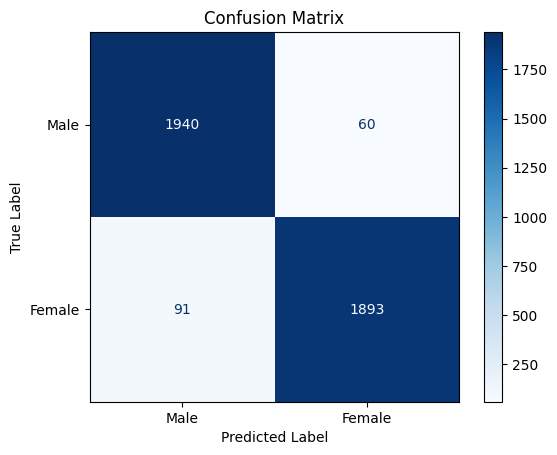

In [27]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Define the test dataset
test_dataset = ImageFolder('TEST', transform=transform)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

true_labels = []
predicted_labels = []

# Iterate through the test dataset to obtain true and predicted labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
labels = ['Male', 'Female']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix Of TEST')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [36]:
 
def testSingleImage(path):
    input_image = preprocess_image(path).to(device)

    with torch.no_grad():
        output = model(input_image)
        probabilities = torch.softmax(output, dim=1)
        predicted_class_index = torch.argmax(probabilities, dim=1).item()
        predicted_class = class_labels[1-predicted_class_index]
        confidence_score = probabilities[0][predicted_class_index].item()

    print(f"Predicted Gender: {predicted_class}, Confidence: {confidence_score:.2f}")

In [38]:
testSingleImage('harun.jpg')

Predicted Gender: Male, Confidence: 0.88
